In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pandas as pd

import analysis_lib

In [3]:
files = os.listdir('logs')
log_files = [ f for f in files if f != ".gitignore" ]
log_files[:2]

['ReFAct-ab208055-1c82-4afb-a7ed-96356bfb9c9b.json',
 'ReFAct-f4de6a68-fc6c-48be-bba7-98ec9bc21217.json']

In [4]:
print(f"Found {len(log_files)} log files")

Found 94 log files


# Analyse the logs

The ReFAct agent comes with a number of configuration settings:

In [5]:
log_file = json.load(open('logs/' + log_files[0]))
config_settings = list(log_file['agent_settings'].keys())
config_settings

['consider_cyclomatic_complexity',
 'make_incremental_changes',
 'use_refactoring_tricks',
 'get_buddy_feedback',
 'use_previous_history',
 'make_plan',
 'dynamic_plan',
 'modify_specific_method',
 'clear_error_after_n',
 'clip_context_window']

As a first experiment, the agent was run on a number of sample projects:

In [6]:
SAMPLE_PROJECTS_DIR = 'samples'
projects = os.listdir(SAMPLE_PROJECTS_DIR)
projects

['js_gilded_rose',
 'java_gilded_rose',
 'js_json_object',
 '.DS_Store',
 'java_tabula',
 'py_yahtzee',
 'java_tennis',
 'java_yahtzee',
 'py_tennis',
 'js_trivia']

Each config setting was enabled exactly once, with all other config settings disabled. This was executed for each sample project, resulting in the following number of agent logs:

In [7]:
len(projects) * len(config_settings) + len(projects)

110

In [8]:
# First, let's load all the logs. Result is a list of dictionaries
log_jsons = []
for log_file in log_files:
    with open(f"logs/{log_file}") as f:
        log_jsons.append(json.load(f))

# Create a dataframe from the list of dictionaries
df = pd.DataFrame(log_jsons)

# the 'execution' column is again a list of dictionaries,
# so we need to explode
df = df.explode("execution")
print("Rows, Cols:", df.shape)
df.head()

Rows, Cols: (3630, 4)


,agent_settings,execution,project,llm
0,"{'consider_cyclomatic_complexity': False, 'mak...",\n You are a professional software develope...,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...","{'thought': 'First, I need to get an overview ...",/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...","{'tool': 'browse_files', 'result': 'Files: ten...",/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...",{'thought': 'I should start by examining the m...,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o
0,"{'consider_cyclomatic_complexity': False, 'mak...","{'tool': 'open_file', 'result': '# -*- coding:...",/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o


In [9]:
# drop all rows where the execution doesn't parse to a dict

df = df[df["execution"].apply(lambda x: isinstance(x, dict))]
print("Rows, Cols:", df.shape)

# drop all rows where "tool" key is not present in the execution dictionary
df = df[df["execution"].apply(lambda x: "tool" in x)]

# we normalize the "agent_settings" column as well as the "execution" column,
# which both contain dictionaries

df_as_list = df.to_dict(orient="records")
df = pd.json_normalize(df_as_list)
print("Rows, Cols:", df.shape)

df.head(3)

Rows, Cols: (3484, 4)
Rows, Cols: (1677, 15)


,project,llm,agent_settings.consider_cyclomatic_complexity,agent_settings.make_incremental_changes,agent_settings.use_refactoring_tricks,agent_settings.get_buddy_feedback,agent_settings.use_previous_history,agent_settings.make_plan,agent_settings.dynamic_plan,agent_settings.modify_specific_method,agent_settings.clear_error_after_n,agent_settings.clip_context_window,execution.tool,execution.result,execution.error
0,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,True,browse_files,"Files: tennis.py, test_tennis.py, test_tennis_...",NaN
1,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,True,open_file,# -*- coding: utf-8 -*-\n\nclass TennisGameDef...,NaN
2,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,True,open_file,# -*- coding: utf-8 -*-\n\nimport pytest\nfrom...,NaN


Now that we've arranged our data, it's time to analyze it. Let's start with the number of commits as a first metric.

In [10]:
# select all columns where the execution.tool is "commit_changes"
df = df[df["execution.tool"] == "commit_changes"]
df[["execution.tool", "project"]].describe()

,execution.tool,project
count,215,215
unique,1,9
top,commit_changes,/Users/I539028/Desktop/Seminar/refactoring-lab...
freq,215,37


In [11]:
# finde the rows where all columns that start with "agent_settings" are set to False
df_all_settings_false = df[~df.filter(like="agent_settings").any(axis=1)]
df_all_settings_false.head(3)

,project,llm,agent_settings.consider_cyclomatic_complexity,agent_settings.make_incremental_changes,agent_settings.use_refactoring_tricks,agent_settings.get_buddy_feedback,agent_settings.use_previous_history,agent_settings.make_plan,agent_settings.dynamic_plan,agent_settings.modify_specific_method,agent_settings.clear_error_after_n,agent_settings.clip_context_window,execution.tool,execution.result,execution.error
42,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,False,commit_changes,Changes committed.,NaN
248,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,False,commit_changes,Changes committed.,NaN
370,/Users/I539028/Desktop/Seminar/refactoring-lab...,gpt-4o,False,False,False,False,False,False,False,False,False,False,commit_changes,No changes to commit for file src/main/java/Ya...,NaN


In [12]:
# get the number of rows where all columns that start with "agent_settings" are set to False
num_commits_all_disabled = len(df_all_settings_false)
num_commits_all_disabled

18

In [13]:
# lambda function to transform the snake_case to Upper Case With Spaces
snake_to_upper = lambda x: x.replace("_", " ").title()

In [14]:
# create a new df, with a row for each agent setting and the number of commits
df_commit_counts = pd.DataFrame()
for agent_setting in config_settings:
    df_commit_counts[agent_setting] = df[f"agent_settings.{agent_setting}"].value_counts().values
df_commit_counts

# apply the snake_to_upper function to the column names
df_commit_counts.columns = df_commit_counts.columns.map(snake_to_upper)

# transpose the dataframe, so that the agent settings are the columns
df_commit_counts = df_commit_counts.T

# drop the first column, since the second column is the number of commits
df_commit_counts = df_commit_counts.drop(df_commit_counts.columns[0], axis=1)
df_commit_counts.columns = ["Number of tested commits"]

# append a row with the number of commits where all agent settings are disabled
df_commit_counts.loc["No Settings Enabled"] = [num_commits_all_disabled]

# sort ascending
df_commit_counts = df_commit_counts.sort_values(by="Number of tested commits", ascending=True)
df_commit_counts

,Number of tested commits
Consider Cyclomatic Complexity,12
Make Incremental Changes,14
Get Buddy Feedback,15
Use Previous History,17
No Settings Enabled,18
Clip Context Window,19
Clear Error After N,20
Dynamic Plan,23
Use Refactoring Tricks,26
Modify Specific Method,33


In [15]:
# get the idx of "No Settings Enabled"
idx = df_commit_counts.index.get_loc("No Settings Enabled")
idx

4

Below is the first set of evaluation, showing the (individually) enabled agent settings and their effect on the number of successful commits.

<Axes: >

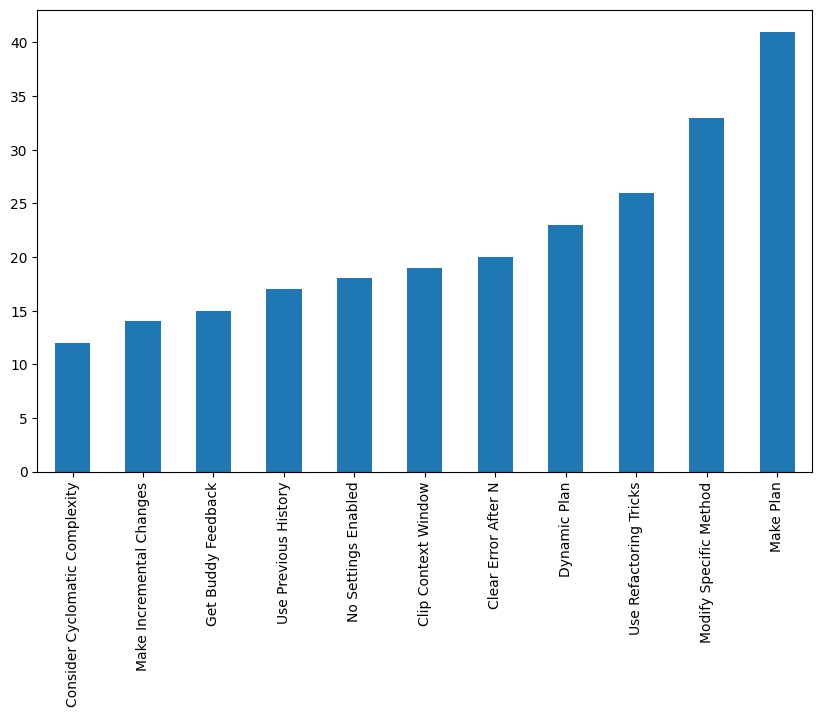

In [16]:
# display as a histogram
df_commit_counts.plot(kind="bar", legend=False, figsize=(10, 6))

## Get insights on failed refactoring related to the settings

In [17]:
df = pd.json_normalize(log_jsons)
df = df.explode("execution")
df = pd.json_normalize(df.to_dict(orient="records"))

# filter the rows where "execution" is NaN
# => this mean execution has been exploded to a dict
df = df[df["execution"].isna()].drop(columns=["execution"])

# filter for "execution.tool" == "overwrite_file"
df = df[df["execution.tool"] == "overwrite_file"]

In [18]:
cols_to_project = [col for col in df.columns if col.startswith("agent_settings")] + ["execution.tool", "execution.result", "execution.error"]

print(cols_to_project)

df_projected = df[cols_to_project]
df_projected.head(3)

['agent_settings.consider_cyclomatic_complexity', 'agent_settings.make_incremental_changes', 'agent_settings.use_refactoring_tricks', 'agent_settings.get_buddy_feedback', 'agent_settings.use_previous_history', 'agent_settings.make_plan', 'agent_settings.dynamic_plan', 'agent_settings.modify_specific_method', 'agent_settings.clear_error_after_n', 'agent_settings.clip_context_window', 'execution.tool', 'execution.result', 'execution.error']


,agent_settings.consider_cyclomatic_complexity,agent_settings.make_incremental_changes,agent_settings.use_refactoring_tricks,agent_settings.get_buddy_feedback,agent_settings.use_previous_history,agent_settings.make_plan,agent_settings.dynamic_plan,agent_settings.modify_specific_method,agent_settings.clear_error_after_n,agent_settings.clip_context_window,execution.tool,execution.result,execution.error
8,False,False,False,False,False,False,False,False,False,True,overwrite_file,Tests passed. Please commit your changes.,NaN
16,False,False,False,False,False,False,False,False,False,True,overwrite_file,Tests passed. Please commit your changes.,NaN
24,False,False,False,False,False,False,False,False,False,True,overwrite_file,Tests passed. Please commit your changes.,NaN


In [19]:
# Combine 'Column1' and 'Column2' into a new column 'Combined'
df_projected['execution.result'] = df_projected['execution.result'].fillna('')
df_projected['execution.error'] = df_projected['execution.error'].fillna('')

/var/folders/0n/h7nytdgn1jqfd2s12vgw2lhw0000gn/T/ipykernel_16183/278286394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_projected['execution.result'] = df_projected['execution.result'].fillna('')
/var/folders/0n/h7nytdgn1jqfd2s12vgw2lhw0000gn/T/ipykernel_16183/278286394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_projected['execution.error'] = df_projected['execution.error'].fillna('')


In [20]:
# if the result is empty, use the error
df_projected['result'] = df_projected['execution.result'] + df_projected['execution.error']
df_projected = df_projected.drop(columns=["execution.result", "execution.error"])
df_projected.head()

/var/folders/0n/h7nytdgn1jqfd2s12vgw2lhw0000gn/T/ipykernel_16183/2147251961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_projected['result'] = df_projected['execution.result'] + df_projected['execution.error']


,agent_settings.consider_cyclomatic_complexity,agent_settings.make_incremental_changes,agent_settings.use_refactoring_tricks,agent_settings.get_buddy_feedback,agent_settings.use_previous_history,agent_settings.make_plan,agent_settings.dynamic_plan,agent_settings.modify_specific_method,agent_settings.clear_error_after_n,agent_settings.clip_context_window,execution.tool,result
8,False,False,False,False,False,False,False,False,False,True,overwrite_file,Tests passed. Please commit your changes.
16,False,False,False,False,False,False,False,False,False,True,overwrite_file,Tests passed. Please commit your changes.
24,False,False,False,False,False,False,False,False,False,True,overwrite_file,Tests passed. Please commit your changes.
32,False,False,False,False,False,False,False,False,False,True,overwrite_file,Tests passed. Please commit your changes.
40,False,False,False,False,False,False,False,False,False,True,overwrite_file,Tests passed. Please commit your changes.


In [21]:
len(df_projected['result'].unique())

241

In [22]:
df_projected['result'].value_counts()

result
Tests passed. Please commit your changes.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [23]:
# if execution.result starts with "Refactoring failed. Changes have been reverted.", then set the value to "Refactoring failed"
df_projected['result'] = df_projected['result'].apply(lambda x: "Refactoring failed" if x.startswith("Refactoring failed. Changes have been reverted.") else x).apply(lambda x: "Refactoring failed" if x.startswith("Command '['git', 'checkout'") else x)
df_projected['result'].value_counts()

result
Refactoring failed                           364
Tests passed. Please commit your changes.    217
Name: count, dtype: int64

In [24]:
# create a new column "success" and set it to True if the result is "Refactoring successful", otherwise False
df_projected['success'] = df_projected['result'] == "Tests passed. Please commit your changes."
# drop all columns that start with "execution."
df_projected = df_projected.drop(columns=["execution.tool", "result"])

In [25]:
df_projected.head(3)

,agent_settings.consider_cyclomatic_complexity,agent_settings.make_incremental_changes,agent_settings.use_refactoring_tricks,agent_settings.get_buddy_feedback,agent_settings.use_previous_history,agent_settings.make_plan,agent_settings.dynamic_plan,agent_settings.modify_specific_method,agent_settings.clear_error_after_n,agent_settings.clip_context_window,success
8,False,False,False,False,False,False,False,False,False,True,True
16,False,False,False,False,False,False,False,False,False,True,True
24,False,False,False,False,False,False,False,False,False,True,True


Next, let's check the amount of failed refactorings for baseline (all configs set to false)

In [26]:
df_projected.columns

Index(['agent_settings.consider_cyclomatic_complexity',
       'agent_settings.make_incremental_changes',
       'agent_settings.use_refactoring_tricks',
       'agent_settings.get_buddy_feedback',
       'agent_settings.use_previous_history', 'agent_settings.make_plan',
       'agent_settings.dynamic_plan', 'agent_settings.modify_specific_method',
       'agent_settings.clear_error_after_n',
       'agent_settings.clip_context_window', 'success'],
      dtype='object')

In [27]:
from matplotlib.patches import Patch
colours = {True: "#44bd32", False: "#273c75"}


<Axes: xlabel='config'>

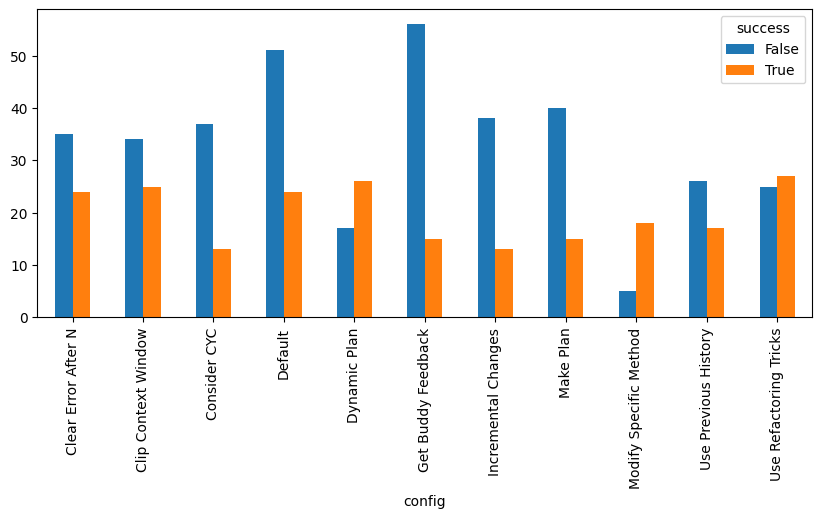

In [28]:
res = []
for r in df_projected.iterrows():
    enabled_agent_settings = [col for col in r[1].keys() if r[1][col] and col.startswith("agent_settings")]
    
    if len(enabled_agent_settings) > 1:
        if "agent_settings.make_plan" and "agent_settings.dynamic_plan" in enabled_agent_settings:
            enabled_agent_settings = ["agent_settings.dynamic_plan"]
        else:
            raise Exception("Multiple agent settings should not be enabled!")

    enabled_agent_settings = [snake_to_upper(x.replace("agent_settings.", "")) for x in enabled_agent_settings]

    res.append({
        "success": r[1]["success"],
        "config": enabled_agent_settings[0] if len(enabled_agent_settings) > 0 else "Default"
    })

res_ = []
for r in res:
    if r['config'] == "Consider Cyclomatic Complexity":
        r['config'] = "Consider CYC"

    if r['config'] == "Make Incremental Changes":
        r['config'] = "Incremental Changes"

    res_.append({
        "success": r["success"],
        "config": r["config"]
    })

res = res_

res_df = pd.DataFrame(res, columns=["success", "config"])
res_df = res_df.groupby("config")["success"].value_counts().unstack()
# make a plot
res_df.plot(kind="bar", stacked=False, figsize=(10, 4), )
    

In [29]:
res_df.sort_values(by=False, ascending=False)

success,False,True
config,,
Get Buddy Feedback,56,15
Default,51,24
Make Plan,40,15
Incremental Changes,38,13
Consider CYC,37,13
Clear Error After N,35,24
Clip Context Window,34,25
Use Previous History,26,17
Use Refactoring Tricks,25,27


In [30]:
# get the ratio of successful refactorings for each agent setting
res_df["success_ratio"] = res_df[True] / (res_df[True] + res_df[False])

In [33]:
res_df

success,False,True,success_ratio
config,,,
Clear Error After N,35,24,0.406780
Clip Context Window,34,25,0.423729
Consider CYC,37,13,0.260000
Default,51,24,0.320000
Dynamic Plan,17,26,0.604651
Get Buddy Feedback,56,15,0.211268
Incremental Changes,38,13,0.254902
Make Plan,40,15,0.272727
Modify Specific Method,5,18,0.782609


In [34]:
# get the success_rati when config = "Default"
default_success_ratio = res_df.loc["Default"]["success_ratio"]

# for all other agent settings, get the difference to the default success ratio and save it in a new column
res_df["diff_to_default"] = res_df["success_ratio"] - default_success_ratio
res_df

success,False,True,success_ratio,diff_to_default
config,,,,
Clear Error After N,35,24,0.406780,0.086780
Clip Context Window,34,25,0.423729,0.103729
Consider CYC,37,13,0.260000,-0.060000
Default,51,24,0.320000,0.000000
Dynamic Plan,17,26,0.604651,0.284651
Get Buddy Feedback,56,15,0.211268,-0.108732
Incremental Changes,38,13,0.254902,-0.065098
Make Plan,40,15,0.272727,-0.047273
Modify Specific Method,5,18,0.782609,0.462609


<Axes: xlabel='config'>

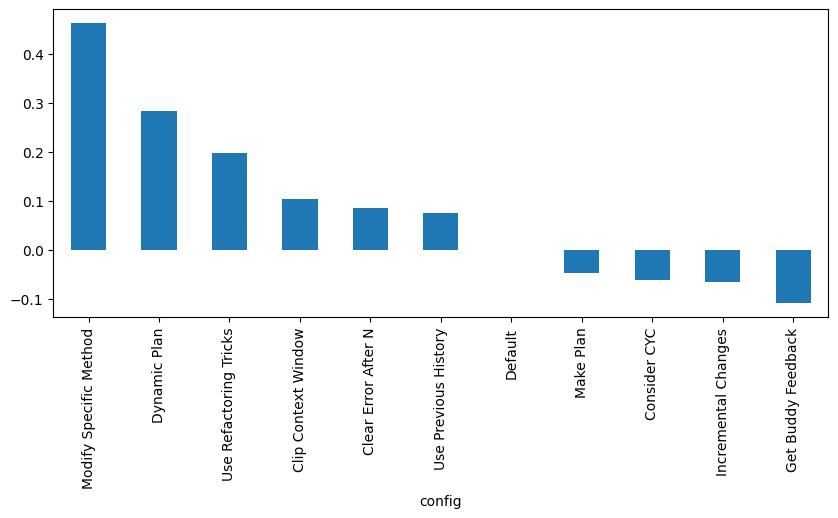

In [36]:
res_df = res_df.sort_values(by="diff_to_default", ascending=False)
# in the config column, replace "Consider Cyclomatic Complexity" with "Consider CYC"

# make a plot
res_df["diff_to_default"].plot(kind="bar", figsize=(10, 4))

<Axes: xlabel='config'>

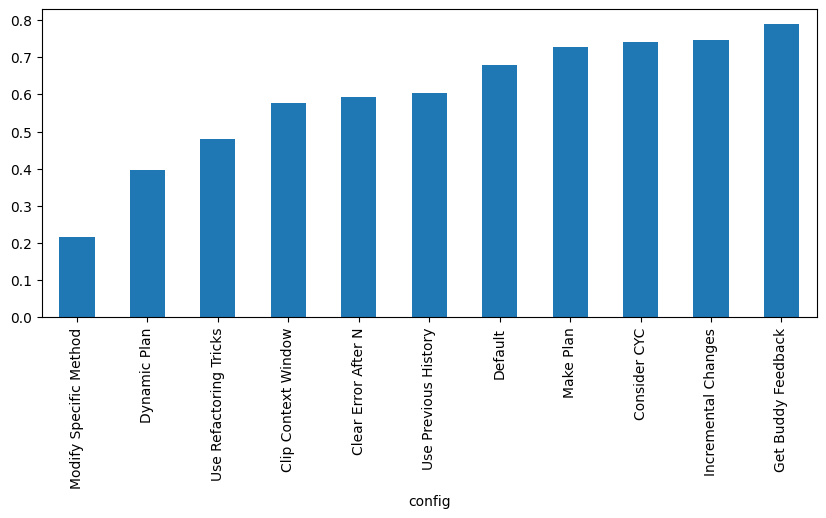

In [46]:
# plot the failure rate
res_df["failure_rate"] = 1 - res_df["success_ratio"]
res_df["failure_rate"].plot(kind="bar", figsize=(10, 4))


## Next, let's try to find out some information about the commits that were made

In [47]:
all_commit_messages = []

for log_json in log_jsons:
    if "execution" in log_json:
        for execution in log_json["execution"]:
            if not isinstance(execution, dict):
                continue
            if "action" in execution and execution["action"] == "commit_changes":
                all_commit_messages.append(execution)

df = pd.json_normalize(all_commit_messages)

# let's get the columns "thought", "action", "tools_input.commit_message" (rename to "commit_message")
df = df[["thought", "action", "tools_input.commit_message"]]
df = df.rename(columns={"tools_input.commit_message": "commit_message"})

# apply the snake_to_upper function to the column names
df.columns = df.columns.map(snake_to_upper)

print("Number of commits:", len(df))
df.head()

Number of commits: 216


,Thought,Action,Commit Message
0,The refactoring of TennisGameDefactored1 was s...,commit_changes,Refactored TennisGameDefactored1 class to impr...
1,The refactoring was successful and all tests h...,commit_changes,Refactored tennis.py to use only the first imp...
2,The tests have passed successfully. I will now...,commit_changes,Refactor: Rename variables and methods in Tenn...
3,The refactoring of the `won_point` method was ...,commit_changes,Refactored won_point method to include a check...
4,"The tests have passed successfully, indicating...",commit_changes,Refactored update_quality function by extracti...


In [48]:
# get the unique commit messages
unique_commit_messages = df["Commit Message"].unique()
len(unique_commit_messages)

201

In [49]:
# display the commit messages that are NOT unique
df["Commit Message"].value_counts().head(10)


Commit Message
Refactored TennisGameDefactored1 class to improve readability and maintainability.                                                            5
Refactored TennisGameDefactored2 class to improve readability and maintainability.                                                            3
Refactored forEach function to use modern JavaScript features like for...of and Object.entries for better readability and maintainability.    3
Refactored currentCategory function to use a map for better readability and maintainability.                                                  3
Refactored GildedRose class to use the Strategy pattern for updating item quality.                                                            2
Refactored wonPoint method in TennisGame1 to use equals for string comparison.                                                                2
Refactor: Rename method 'feq' to 'isApproximatelyEqual' for better clarity and update all references.                    

In [50]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline

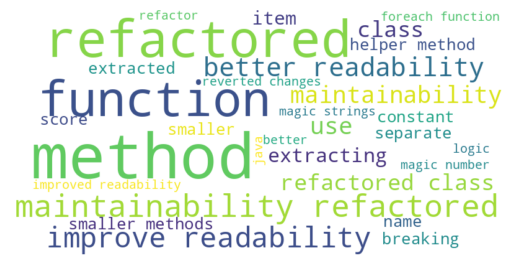

In [102]:
SPECIFIC_WORDS = ["update_quality", "tennisgame", "updatequality", "tennisgame1", "gildedrose", "tojsonobject", "getscore", "tennisgamedefactored1"]

text = " ".join(df["Commit Message"])
text = " ".join([t.lower().strip() for t in text.split() if t.lower().strip() not in SPECIFIC_WORDS])

# Create and generate a word cloud image:

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white", scale=2).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

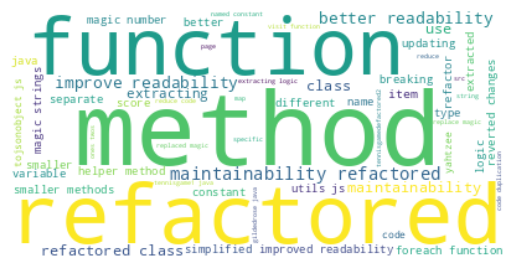

In [100]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", repeat=False).generate(text)
wordcloud.to_file("wordcloud.png")


# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [63]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

import torch
torch.set_num_threads(1)
print("CUDA", torch.cuda.is_available())

CUDA False


In [64]:
from collections import defaultdict

def embed_and_cluster(corpus, clustering_model, embedding_model):

    embedded_corpus = embedding_model.encode(corpus)
    embedded_corpus.shape

    clustering_model.fit(embedded_corpus)
    cluster_assignment = clustering_model.labels_

    clusters = defaultdict(list)
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        clusters[cluster_id].append(corpus[sentence_id])

    return clusters


In [69]:
from sklearn.cluster import KMeans

# try out KMeans clutering
num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters)

corpus = df["Commit Message"].values
clustered_sentences = embed_and_cluster(corpus, clustering_model, embedding_model)


In [71]:
[len(c) for c in clustered_sentences.values()]
clusters = [c for c in clustered_sentences.values()]

with open(f"./clustered_commit_messages_kmean_{num_clusters}s.json", "w") as f:
    json.dump({int(k): v for k, v in clustered_sentences.items()}, f, indent=2)

In [68]:
from sklearn.cluster import AgglomerativeClustering

# try out agglomerative clutering
clustering_model = AgglomerativeClustering(
    n_clusters=10 # , distance_threshold=3
)
clustered_sentences = embed_and_cluster(corpus, clustering_model, embedding_model)

print([len(c) for c in clustered_sentences.values()])
clusters = [c for c in clustered_sentences.values()]

with open("./clustered_commit_messages.json", "w") as f:
    json.dump({int(k): v for k, v in clustered_sentences.items()}, f, indent=2)

[71, 17, 8, 28, 6, 23, 24, 15, 9, 15]


In [72]:
cluster_labels = [analysis_lib.label_clusters_llm(cluster) for cluster in clusters]
cluster_labels

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


['Refactoring TennisGame Classes for Readability and Maintainability',
 'Refactoring Methods in TennisGame Classes',
 'Refactoring the `update_quality` Function for Improved Readability and Maintainability',
 'Refactoring for Improved Readability and Maintainability',
 'Refactoring for Code Reusability and Readability',
 '**Refactoring and Reverting Changes to `toJSONObject` Function**',
 '**Code Refactoring and Reversion**',
 'Refactoring for Readability and Maintainability in GildedRose Class']

In [73]:
summarized_clusters = analysis_lib.summarize_clusters(cluster_labels)
summarized_clusters

['Refactoring TennisGame Classes',
 'Refactoring TennisGame Methods',
 'Refactoring update_quality Function',
 'Improved Readability Maintainability',
 'Code Reusability Readability',
 'Refactoring Reverting toJSONObject',
 'Code Refactoring Reversion',
 'Readability Maintainability GildedRose']

In [74]:
unique = list(set(summarized_clusters))
print(len(unique))
unique

8


['Refactoring TennisGame Methods',
 'Improved Readability Maintainability',
 'Code Refactoring Reversion',
 'Code Reusability Readability',
 'Refactoring Reverting toJSONObject',
 'Readability Maintainability GildedRose',
 'Refactoring TennisGame Classes',
 'Refactoring update_quality Function']

In [75]:
words = []
for s in unique:
    words.extend(s.split(" "))
pd.Series(words).value_counts(True)[:10]

Refactoring        0.208333
Readability        0.125000
TennisGame         0.083333
Maintainability    0.083333
Code               0.083333
Methods            0.041667
Improved           0.041667
Reversion          0.041667
Reusability        0.041667
Reverting          0.041667
Name: proportion, dtype: float64

### Preliminary Observation
It is observed, that often times the clusters are formed based on e.g. the name of the refactored code file / the refactored method. However, what we want, is the clusters to be formed based on the actual refactoring technique / approach / ... that was applied. Hence, we try to remove certain keywords from the sentences (commit messages).

In [76]:
# observation: clusters are driven by specific names of files or functions
updated_corpus = []
for commit_message in df["Commit Message"].values:
    updated_corpus.append(analysis_lib.remove_specific_terms(commit_message))

clustered_sentences_updated = embed_and_cluster(updated_corpus, clustering_model, embedding_model)

with open("./clustered_commit_messages_updated.json", "w") as f:
    json.dump({int(k): v for k, v in clustered_sentences_updated.items()}, f, indent=2)

In [84]:
cluster_labels_updated = [analysis_lib.label_clusters_llm(cluster) for cluster in clustered_sentences_updated.values()]
cluster_labels_updated

['**Refactoring for Readability and Maintainability**',
 'Refactoring for Readability and Maintainability',
 'Refactoring and Reverting Changes',
 'Refactoring Functions for Improved Readability and Maintainability',
 'Refactoring `foreach` Function for Readability and Maintainability',
 '"Code Refactoring and Reversion"',
 'Refactoring and Code Organization',
 'Refactoring and Code Improvement']

In [83]:
summarized_clusters = analysis_lib.summarize_clusters(cluster_labels_updated)
summarized_clusters

['Refactoring and Maintainability']

In [79]:
unique = list(set(summarized_clusters))
print(len(unique))
unique

1


['Refactoring and Maintainability']

In [85]:
words = []
for s in unique:
    words.extend(s.split(" "))
pd.Series(words).value_counts(True)[:10]

Refactoring        0.333333
and                0.333333
Maintainability    0.333333
Name: proportion, dtype: float64